In [1]:
import numpy as np
from array import *
import copy
import random
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
tf.__version__

'2.3.1'

In [2]:
dataset = pd.read_csv('icml_face_data.csv', low_memory = False)
dataset_copy = copy.copy(dataset)

In [3]:
dataset_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [4]:
dataset_copy.head(2)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...


In [5]:
dataset_copy = dataset_copy.drop([' Usage'], axis = 1)

In [6]:
dataset_copy = dataset_copy[dataset_copy.emotion != 2]
dataset_copy = dataset_copy[dataset_copy.emotion != 6]

In [7]:
dataset_copy['emotion'].unique()

array([0, 4, 3, 5, 1], dtype=int64)

In [8]:
dataset_copy['emotion'] = dataset_copy['emotion'].replace(to_replace = [4, 5], value = [2, 4])

In [9]:
dataset_copy['emotion'].unique()

array([0, 2, 3, 4, 1], dtype=int64)

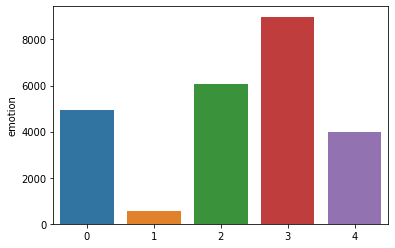

In [10]:
sns.barplot(x = dataset_copy['emotion'].value_counts().index, y = dataset_copy['emotion'].value_counts())

In [11]:
def string2array(x):
    return np.array(x.split(' ')).reshape(48, 48).astype('float32')
dataset_copy[' pixels'] = dataset_copy[' pixels'].apply(lambda x: string2array(x))


In [12]:
dataset_copy = dataset_copy.reset_index(drop = True)

In [13]:
dataset_copy.head(5)

,emotion,pixels
0,0,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63..."
1,0,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11..."
2,2,"[[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20..."
3,2,"[[20.0, 17.0, 19.0, 21.0, 25.0, 38.0, 42.0, 42..."
4,3,"[[77.0, 78.0, 79.0, 79.0, 78.0, 75.0, 60.0, 55..."


In [14]:
emotion = ['Angry', 'Disgust', 'Sad', 'Happy', 'Surprise']

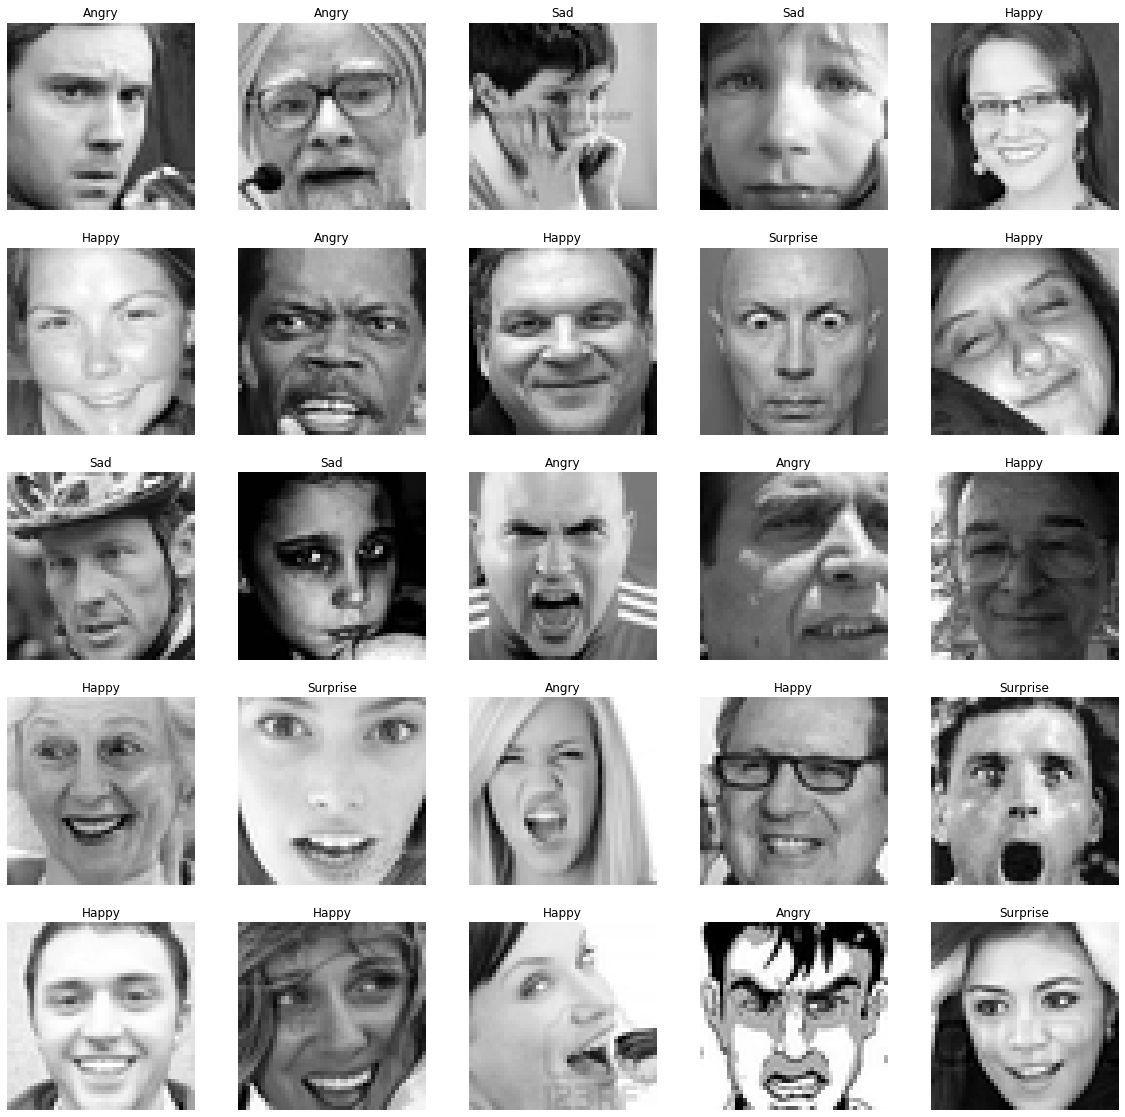

In [15]:
l_grid = 5
w_grid = 5
fig, axes = plt.subplots(l_grid, w_grid, figsize = (20, 20))
axes = axes.ravel()
for i in range(0, len(axes)):
    axes[i].imshow(dataset_copy[' pixels'][i], cmap = 'gray')
    axes[i].set_title(emotion[dataset_copy['emotion'][i]])
    axes[i].axis('off')

In [16]:
image = dataset_copy.iloc[:, -1].values
y = dataset_copy.iloc[:, 0:-1].values

In [17]:
image.shape, y.shape

((24568,), (24568, 1))

In [18]:
image = image/255.0
x = np.empty((len(image), 48, 48, 1))
for i in range(len(image)):
    x[i,] = np.expand_dims(image[i], axis = 2)
x = np.asarray(x).astype(np.float32)
from keras.utils import to_categorical
y = to_categorical(y)
x.shape, y.shape

((24568, 48, 48, 1), (24568, 5))

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size = 0.6, random_state = 42)

In [20]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((18426, 48, 48, 1),
 (18426, 5),
 (2456, 48, 48, 1),
 (2456, 5),
 (3686, 48, 48, 1),
 (3686, 5))

In [35]:
def res_block(X, filter, stage):
    # CONVOLUTIONAL BLOCK
    X_copy = X
    f1, f2, f3 = filter
    #main path
    X = tf.keras.layers.Conv2D(filters = f1, kernel_size = (1, 1), strides = (1, 1), name = 'res_'+str(stage)+'_conv_a', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))(X)
    X = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    
    X = tf.keras.layers.Conv2D(filters = f2, kernel_size = (3, 3), strides = (1, 1), name = 'res_'+str(stage)+'_conv_b', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0), padding = 'same')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    
    X = tf.keras.layers.Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1), name = 'res_'+str(stage)+'_conv_c', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_c')(X)
    
    #short path
    X_copy = tf.keras.layers.Conv2D(filters = f3, kernel_size=(1, 1), strides = (1, 1), name = 'res_'+str(stage)+'_conv_copy', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))(X_copy)
    X_copy = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(X_copy)
    X_copy = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)
    
    #ADD
    X = tf.keras.layers.Add()([X, X_copy])
    X = tf.keras.layers.Activation('relu')(X)
    
    #IDENTITY BLOCK1
    #main path
    X = tf.keras.layers.Conv2D(filters = f1, kernel_size = (1, 1), strides = (1, 1),name ='res_'+str(stage)+'_identity_1_a', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    
    X = tf.keras.layers.Conv2D(filters = f2, kernel_size = (3, 3), strides = (1, 1),name ='res_'+str(stage)+'_identity_1_b', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0), padding = 'same')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    
    X = tf.keras.layers.Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity_1_c')(X)
    
    #ADD
    X = tf.keras.layers.Add()([X, X_copy])
    X = tf.keras.layers.Activation('relu')(X)
    
    #IDENTITY BLOCK2
    
    X_copy = X
    
    #main path
    X = tf.keras.layers.Conv2D(filters = f1, kernel_size = (1, 1), strides = (1, 1),name ='res_'+str(stage)+'_identity_2_a', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    
    X = tf.keras.layers.Conv2D(filters = f2, kernel_size = (3, 3), strides = (1, 1),name ='res_'+str(stage)+'_identity_2_b', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0), padding = 'same')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    
    X = tf.keras.layers.Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_identity_2_c')(X)
    
    #ADD
    X = tf.keras.layers.Add()([X, X_copy])
    X = tf.keras.layers.Activation('relu')(X)
    
    return(X)

In [36]:
input_shape = (48, 48, 1)
X_input = tf.keras.Input(input_shape)
X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)

#stage1
X = tf.keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))(X)
X = tf.keras.layers.BatchNormalization(axis = 3, name = 'conv1_bn1')(X)
X = tf.keras.layers.Activation('relu')(X)
X = tf.keras.layers.MaxPool2D(pool_size = (3, 3), strides = (2, 2))(X)

#stage2
X = res_block(X, filter = [64, 64, 256], stage = 2)

#stage3
X = res_block(X, filter = [128, 128, 512], stage = 3)

#avarage pooloing
X = tf.keras.layers.AveragePooling2D((2, 2), name = 'avarage_pooling')(X)
X = tf.keras.layers.Flatten()(X)

X = tf.keras.layers.Dense(units = 500, activation = 'relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(units = 5, activation = 'softmax')(X)

classifier = tf.keras.models.Model(inputs = X_input, outputs = X)
classifier.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 54, 54, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   3200        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1_bn1 (BatchNormalization)  (None, 24, 24, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

In [37]:
classifier.compile(optimizer = tf.keras.optimizers.Adam(0.0001) ,loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [38]:
train_datagen = ImageDataGenerator(rotation_range = 15, width_shift_range = 0.2, height_shift_range = 0.15,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = "nearest")

In [39]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath = 'model/facial_emotion_detection.h5', monitor = 'val_accuracy', verbose = 1,
                             save_best_only = True, mode = 'max')


In [40]:
epochs_history = classifier.fit(train_datagen.flow(x_train, y_train), validation_data = (x_valid, y_valid), 
                                callbacks = checkpoint, epochs = 120)

Epoch 1/120
576/576 [==============================] - ETA: 0s - loss: 1.4500 - accuracy: 0.3504
Epoch 00001: val_accuracy improved from -inf to 0.37744, saving model to model\facial_emotion_detection.h5
576/576 [==============================] - 75s 130ms/step - loss: 1.4500 - accuracy: 0.3504 - val_loss: 1.3835 - val_accuracy: 0.3774
Epoch 2/120
576/576 [==============================] - ETA: 0s - loss: 1.3754 - accuracy: 0.3882
Epoch 00002: val_accuracy improved from 0.37744 to 0.40635, saving model to model\facial_emotion_detection.h5
576/576 [==============================] - 80s 139ms/step - loss: 1.3754 - accuracy: 0.3882 - val_loss: 1.3876 - val_accuracy: 0.4064
Epoch 3/120
576/576 [==============================] - ETA: 0s - loss: 1.3320 - accuracy: 0.4140
Epoch 00003: val_accuracy improved from 0.40635 to 0.42386, saving model to model\facial_emotion_detection.h5
576/576 [==============================] - 81s 140ms/step - loss: 1.3320 - accuracy: 0.4140 - val_loss: 1.3234 - v

Epoch 27/120
576/576 [==============================] - ETA: 0s - loss: 0.8785 - accuracy: 0.6513
Epoch 00027: val_accuracy did not improve from 0.66124
576/576 [==============================] - 64s 111ms/step - loss: 0.8785 - accuracy: 0.6513 - val_loss: 0.9986 - val_accuracy: 0.6006
Epoch 28/120
576/576 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.6513
Epoch 00028: val_accuracy did not improve from 0.66124
576/576 [==============================] - 65s 113ms/step - loss: 0.8721 - accuracy: 0.6513 - val_loss: 1.0987 - val_accuracy: 0.5656
Epoch 29/120
576/576 [==============================] - ETA: 0s - loss: 0.8619 - accuracy: 0.6624
Epoch 00029: val_accuracy did not improve from 0.66124
576/576 [==============================] - 64s 111ms/step - loss: 0.8619 - accuracy: 0.6624 - val_loss: 0.8854 - val_accuracy: 0.6527
Epoch 30/120
576/576 [==============================] - ETA: 0s - loss: 0.8495 - accuracy: 0.6663
Epoch 00030: val_accuracy did not improve

Epoch 55/120
576/576 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.7175
Epoch 00055: val_accuracy did not improve from 0.71987
576/576 [==============================] - 64s 111ms/step - loss: 0.7252 - accuracy: 0.7175 - val_loss: 0.7728 - val_accuracy: 0.7089
Epoch 56/120
576/576 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.7176
Epoch 00056: val_accuracy improved from 0.71987 to 0.72842, saving model to model\facial_emotion_detection.h5
576/576 [==============================] - 64s 112ms/step - loss: 0.7274 - accuracy: 0.7176 - val_loss: 0.7058 - val_accuracy: 0.7284
Epoch 57/120
576/576 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.7207
Epoch 00057: val_accuracy did not improve from 0.72842
576/576 [==============================] - 64s 112ms/step - loss: 0.7128 - accuracy: 0.7207 - val_loss: 0.7781 - val_accuracy: 0.7003
Epoch 58/120
576/576 [==============================] - ETA: 0s - loss: 0.7143 - acc

Epoch 83/120
576/576 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.7507
Epoch 00083: val_accuracy did not improve from 0.73453
576/576 [==============================] - 111s 193ms/step - loss: 0.6425 - accuracy: 0.7507 - val_loss: 0.7331 - val_accuracy: 0.7223
Epoch 84/120
576/576 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.7502
Epoch 00084: val_accuracy did not improve from 0.73453
576/576 [==============================] - 111s 194ms/step - loss: 0.6360 - accuracy: 0.7502 - val_loss: 0.7585 - val_accuracy: 0.7134
Epoch 85/120
576/576 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.7538
Epoch 00085: val_accuracy did not improve from 0.73453
576/576 [==============================] - 111s 193ms/step - loss: 0.6391 - accuracy: 0.7538 - val_loss: 0.7823 - val_accuracy: 0.6991
Epoch 86/120
576/576 [==============================] - ETA: 0s - loss: 0.6423 - accuracy: 0.7498
Epoch 00086: val_accuracy did not impr

Epoch 111/120
576/576 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.7729
Epoch 00111: val_accuracy did not improve from 0.74919
576/576 [==============================] - 112s 194ms/step - loss: 0.5847 - accuracy: 0.7729 - val_loss: 0.7682 - val_accuracy: 0.7178
Epoch 112/120
576/576 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.7738
Epoch 00112: val_accuracy did not improve from 0.74919
576/576 [==============================] - 111s 193ms/step - loss: 0.5804 - accuracy: 0.7738 - val_loss: 0.7304 - val_accuracy: 0.7284
Epoch 113/120
576/576 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.7767
Epoch 00113: val_accuracy did not improve from 0.74919
576/576 [==============================] - 111s 193ms/step - loss: 0.5783 - accuracy: 0.7767 - val_loss: 0.7337 - val_accuracy: 0.7207
Epoch 114/120
576/576 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.7727
Epoch 00114: val_accuracy did not 

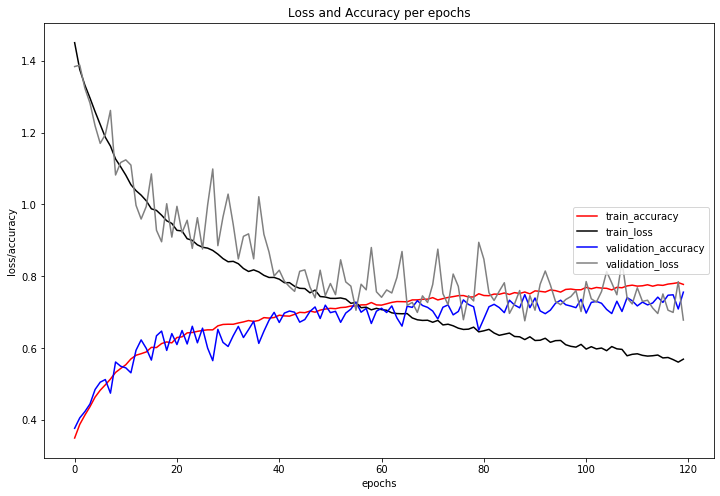

In [41]:
plt.figure(figsize = (12, 8))
plt.plot(epochs_history.history['accuracy'], c = 'red', label="train_accuracy")
plt.plot(epochs_history.history['loss'], c = 'black', label = 'train_loss')
plt.plot(epochs_history.history['val_accuracy'], c = 'blue', label = 'validation_accuracy')
plt.plot(epochs_history.history['val_loss'], c = 'gray', label = 'validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss/accuracy')
plt.title('Loss and Accuracy per epochs')
plt.legend(loc = 'center right')
plt.show()

In [53]:
_, accuracy = classifier.evaluate(x_test, y_test, batch_size = 32)
print('accuracy in test_set: %.2f' %(accuracy*100),'%')

116/116 [==============================] - 4s 37ms/step - loss: 0.6573 - accuracy: 0.7453
accuracy in test_set: 74.53 %


In [45]:
y_pred = np.argmax(classifier.predict(x_test), axis = 1)

In [46]:
y_pred

array([2, 3, 0, ..., 2, 3, 3], dtype=int64)

In [47]:
y_test_true = np.argmax(y_test, axis = 1)

In [48]:
y_test_true

array([0, 3, 3, ..., 0, 3, 3], dtype=int64)

In [49]:
from sklearn.metrics import classification_report
report = classification_report(y_pred, y_test_true)
print(report)

              precision    recall  f1-score   support

           0       0.56      0.61      0.59       665
           1       0.58      0.69      0.63        61
           2       0.73      0.65      0.69      1068
           3       0.84      0.86      0.85      1322
           4       0.79      0.83      0.81       570

    accuracy                           0.75      3686
   macro avg       0.70      0.73      0.71      3686
weighted avg       0.75      0.75      0.75      3686



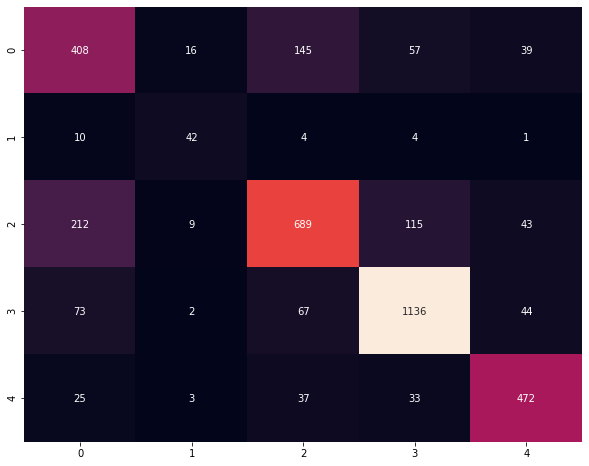

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_test_true)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, cbar = False, fmt = 'd')

In [51]:
def draw_test(image, prediction, true):
    BLACK = [0, 0, 0]
    expanded_image = cv2.copyMakeBorder(image, 0, 0, 0, image.shape[0], cv2.BORDER_CONSTANT, value = BLACK)
    #expanded_image = cv2.cvtColor(expanded_image)
    cv2.putText(expanded_image, prediction, (240, 90), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 2)
    cv2.putText(expanded_image, true, (240, 60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 2)
    cv2.imshow('prediction', expanded_image)

for i in range(0, 30):
    array = np.random.randint(0, len(x_test))
    input_image = x_test[array]
    new_image = cv2.resize(input_image, None, fx = 5, fy = 5, interpolation = cv2.INTER_CUBIC)
    input_image = input_image.reshape(1, 48, 48, 1)
    prediction = 'predicted: ' + emotion[y_pred[array]]
    true = 'true: ' + emotion[y_test_true[array]]
    draw_test(new_image, prediction, true)
    cv2.waitKey()
cv2.destroyAllWindows()